In [29]:
import torch
import torchtune
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd # Import pandas for the summary table
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report

# Set a consistent device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


# # Load and Prepare the Fashion-MNIST Dataset


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the Fashion-MNIST dataset
train_dataset_full = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

# Split training data into train (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names for plotting
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]


Using device: cuda


In [30]:

# Build the Artificial Neural Network (ANN)


# Define the ANN architecture
class FashionMNIST_ANN(nn.Module):
    def __init__(self):
        super(FashionMNIST_ANN, self).__init__()
        # Flatten 28x28 input images into 784-length vectors
        self.fc1 = nn.Linear(28*28, 256)  # Input - Hidden layer 1
        self.fc2 = nn.Linear(256, 128)    # Hidden layer 1 - Hidden layer 2
        self.fc3 = nn.Linear(128, 10)     # Hidden layer 2 - Output layer (10 classes)

        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Flatten image into 1D vector per sample
        x = x.view(x.shape[0], -1)

        # Hidden layer 1 with ReLU + dropout (First dropout kept)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Hidden layer 2 with ReLU
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc3(x)

        return x

# Instantiate the model
model_ann = FashionMNIST_ANN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)

# Print model summary
print("\n Model Summary : ")
print(model_ann)


 Model Summary : 
FashionMNIST_ANN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [31]:

# Train and Evaluate the ANN Model


# If GPU is available, use it for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
model_ann.to(device)

# Set hyperparameters
num_epochs = 10

# Track metrics
train_losses, val_losses, val_accuracies = [], [], []
train_accuracies = []

for epoch in range(num_epochs):
    # TRAINING PHASE
    model_ann.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_ann(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for the batch
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()


    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)


    # VALIDATION PHASE
    model_ann.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ann(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Train Acc: {train_accuracy:.2f}% "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val Acc: {val_accuracy:.2f}%")


Using device: cuda
Epoch [1/10] Train Loss: 0.5621 Train Acc: 79.57% Val Loss: 0.4234 Val Acc: 84.58%
Epoch [2/10] Train Loss: 0.4185 Train Acc: 84.84% Val Loss: 0.3879 Val Acc: 85.85%
Epoch [3/10] Train Loss: 0.3807 Train Acc: 86.06% Val Loss: 0.3590 Val Acc: 87.16%
Epoch [4/10] Train Loss: 0.3600 Train Acc: 86.79% Val Loss: 0.3568 Val Acc: 86.83%
Epoch [5/10] Train Loss: 0.3427 Train Acc: 87.45% Val Loss: 0.3472 Val Acc: 87.67%
Epoch [6/10] Train Loss: 0.3289 Train Acc: 87.84% Val Loss: 0.3261 Val Acc: 88.14%
Epoch [7/10] Train Loss: 0.3140 Train Acc: 88.45% Val Loss: 0.3315 Val Acc: 88.08%
Epoch [8/10] Train Loss: 0.3070 Train Acc: 88.64% Val Loss: 0.3454 Val Acc: 87.71%
Epoch [9/10] Train Loss: 0.2960 Train Acc: 88.93% Val Loss: 0.3198 Val Acc: 88.30%
Epoch [10/10] Train Loss: 0.2881 Train Acc: 89.44% Val Loss: 0.3286 Val Acc: 88.33%


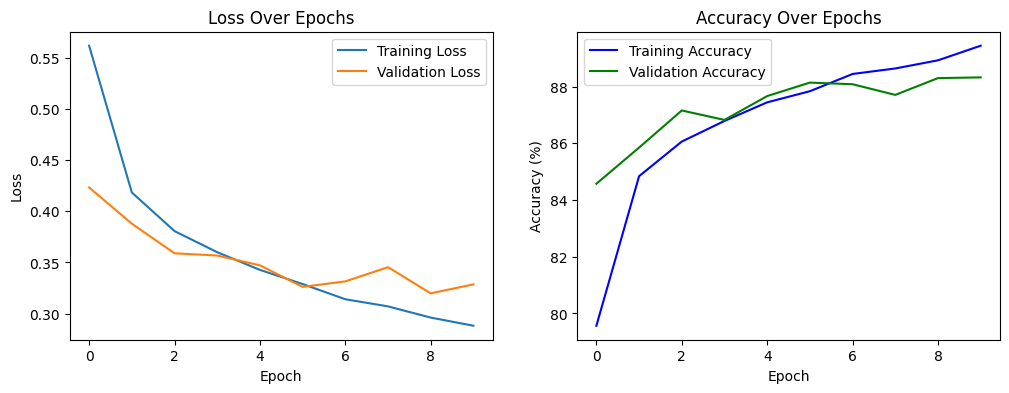

In [32]:
# PLOT TRAINING CURVES
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Training Accuracy", color="blue")
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()

In [33]:
# TESTING PHASE
model_ann.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ann(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 87.46%


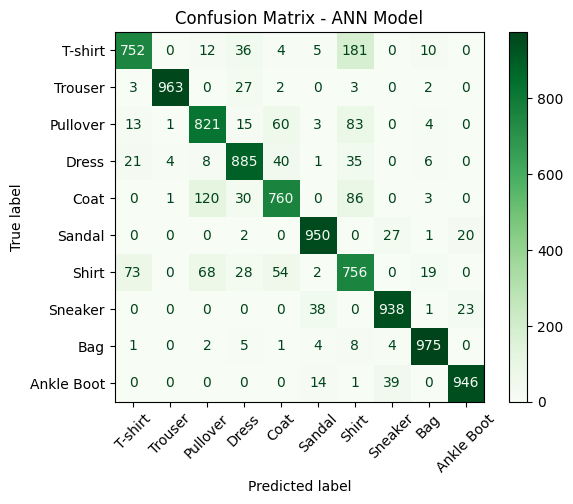

In [34]:
# CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[
                                  "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - ANN Model")
plt.show()

In [35]:
#  Print final accuracies for ANN neatly

print(f"ANN Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"ANN Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"ANN Test Accuracy: {test_accuracy:.2f}%")

ANN Training Accuracy: 89.44%
ANN Validation Accuracy: 88.33%
ANN Test Accuracy: 87.46%


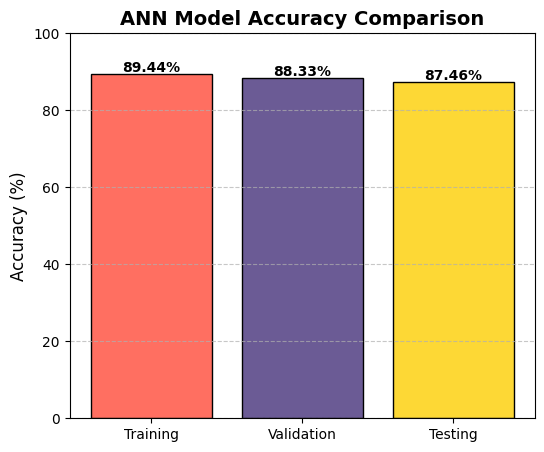

In [36]:
#  Use your computed accuracies for ANN
ann_train_acc = train_accuracies[-1]
ann_val_acc = val_accuracies[-1]
ann_test_acc = test_accuracy

# Data for plotting
phases = ['Training', 'Validation', 'Testing']
accuracies = [ann_train_acc, ann_val_acc, ann_test_acc]

#  Plot bar graph
plt.figure(figsize=(6,5))
bars = plt.bar(phases, accuracies, color=['#FF6F61', '#6B5B95', '#FDD835'], edgecolor='black')

#  Labels and title
plt.title('ANN Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#  Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.2f}%', ha='center', fontweight='bold')

plt.show()


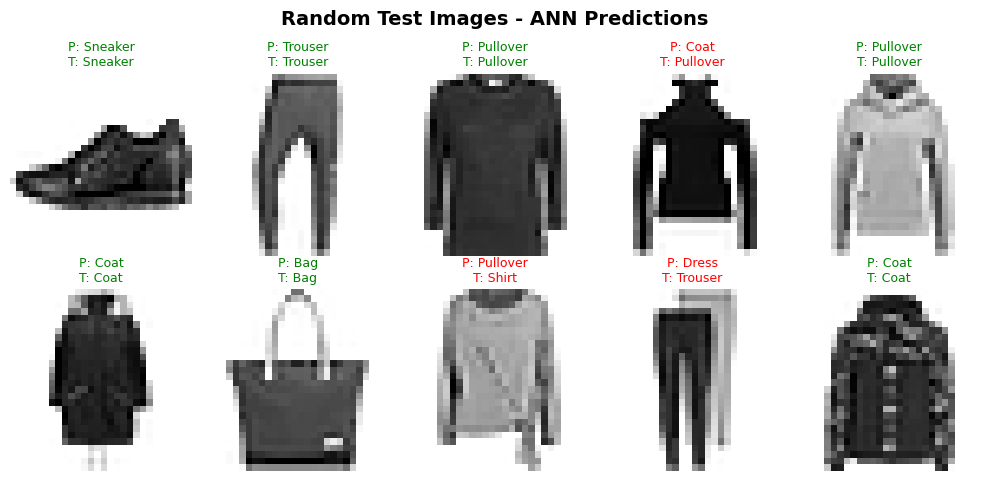

In [37]:
# Set model to evaluation mode
model_ann.eval()

# Fetch all test images and labels from the loader
all_images, all_labels = [], []
for imgs, lbls in test_loader:
    all_images.append(imgs)
    all_labels.append(lbls)
images = torch.cat(all_images)
labels = torch.cat(all_labels)

# Choose 10 random test indices
indices = random.sample(range(len(images)), 10)
sample_images = images[indices]
sample_labels = labels[indices]

# Predict with ANN
with torch.no_grad():
    outputs = model_ann(sample_images.view(sample_images.size(0), -1).to(device))
    _, preds = torch.max(outputs, 1)

# Class names
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Plot clearer, random test images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i][0], cmap="binary", interpolation="nearest")  # sharper
    true_label = classes[sample_labels[i]]
    pred_label = classes[preds[i]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    ax.axis("off")

plt.suptitle("Random Test Images - ANN Predictions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# **CNN MODEL IMPLEMENTATION**

In [38]:
# STEP 4: Build and Evaluate a Convolutional Neural Network (CNN)
# Define the CNN architecture
class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super(FashionMNIST_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # Output: 32×28×28
        self.pool = nn.MaxPool2d(2, 2)                            # Output: 32×14×14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64×14×14 -> after pool 64×7×7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Conv1 + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))   # Conv2 + ReLU + MaxPool
        x = x.view(-1, 64 * 7 * 7)             # Flatten feature maps
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                        # Output logits for 10 classes
        return x


# Initialize the model, loss, and optimizer
model_cnn = FashionMNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Train the CNN
num_epochs = 10
train_losses_cnn, val_losses_cnn, val_accuracies_cnn = [], [], []
train_accuracies_cnn = [] # Add this list to store training accuracies


for epoch in range(num_epochs):
    # TRAINING
    model_cnn.train()
    running_loss = 0.0
    correct_train_cnn, total_train_cnn = 0, 0 # Initialize train accuracy counters
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for the batch
        _, predicted_train_cnn = torch.max(outputs.data, 1)
        total_train_cnn += labels.size(0)
        correct_train_cnn += (predicted_train_cnn == labels).sum().item()

    avg_train_loss_cnn = running_loss / len(train_loader)
    train_accuracy_cnn = 100 * correct_train_cnn / total_train_cnn # Calculate epoch training accuracy
    train_accuracies_cnn.append(train_accuracy_cnn) # Store epoch training accuracy


    # VALIDATION
    model_cnn.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    train_losses_cnn.append(avg_train_loss_cnn)
    val_losses_cnn.append(avg_val_loss)
    val_accuracies_cnn.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss_cnn:.4f} "
          f"Train Acc: {train_accuracy_cnn:.2f}% " # Print training accuracy
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val Acc: {val_accuracy:.2f}%")



Epoch [1/10] Train Loss: 0.5024 Train Acc: 81.97% Val Loss: 0.3488 Val Acc: 86.68%
Epoch [2/10] Train Loss: 0.3251 Train Acc: 88.22% Val Loss: 0.2886 Val Acc: 89.77%
Epoch [3/10] Train Loss: 0.2755 Train Acc: 89.94% Val Loss: 0.2522 Val Acc: 90.67%
Epoch [4/10] Train Loss: 0.2451 Train Acc: 90.94% Val Loss: 0.2581 Val Acc: 90.58%
Epoch [5/10] Train Loss: 0.2215 Train Acc: 91.75% Val Loss: 0.2330 Val Acc: 91.37%
Epoch [6/10] Train Loss: 0.2003 Train Acc: 92.45% Val Loss: 0.2338 Val Acc: 91.66%
Epoch [7/10] Train Loss: 0.1820 Train Acc: 93.27% Val Loss: 0.2324 Val Acc: 91.86%
Epoch [8/10] Train Loss: 0.1670 Train Acc: 93.69% Val Loss: 0.2420 Val Acc: 91.67%
Epoch [9/10] Train Loss: 0.1491 Train Acc: 94.40% Val Loss: 0.2311 Val Acc: 91.81%
Epoch [10/10] Train Loss: 0.1362 Train Acc: 94.85% Val Loss: 0.2423 Val Acc: 91.85%


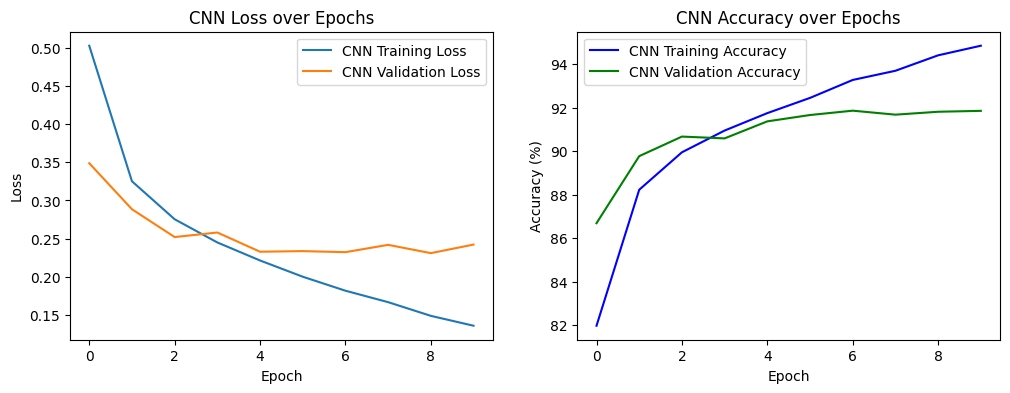

In [39]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses_cnn, label="CNN Training Loss")
plt.plot(val_losses_cnn, label="CNN Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies_cnn, label="CNN Training Accuracy", color="blue") # Plot training accuracy
plt.plot(val_accuracies_cnn, label="CNN Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CNN Accuracy over Epochs")
plt.legend()
plt.show()

In [40]:
# Evaluate on test set
model_cnn.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy_cnn = 100 * correct / total
print(f"\nFinal CNN Test Accuracy: {test_accuracy_cnn:.2f}%")


Final CNN Test Accuracy: 91.14%


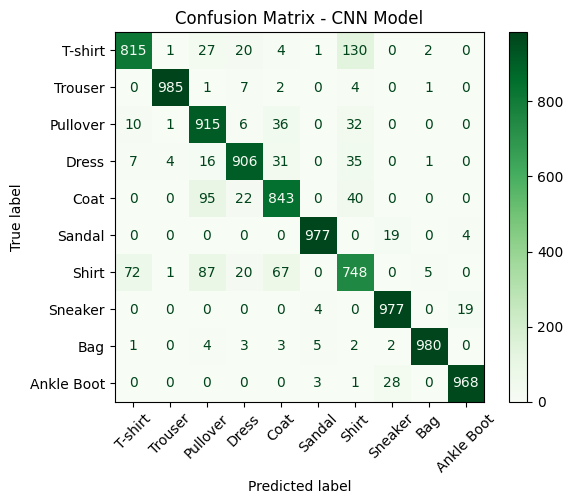

In [41]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[
                                  "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - CNN Model")
plt.show()

In [42]:
# Print final accuracies for CNN

print(f"CNN Training Accuracy: {train_accuracies_cnn[-1]:.2f}%")
print(f"CNN Validation Accuracy: {val_accuracies_cnn[-1]:.2f}%")
print(f"CNN Test Accuracy: {test_accuracy_cnn:.2f}%")


CNN Training Accuracy: 94.85%
CNN Validation Accuracy: 91.85%
CNN Test Accuracy: 91.14%


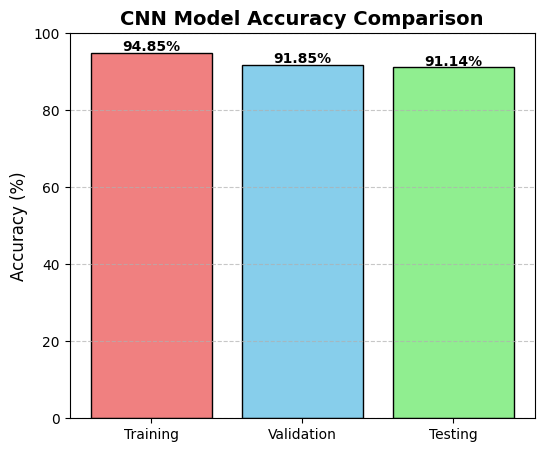

In [43]:
#  Using  computed accuracies
cnn_train_acc = train_accuracies_cnn[-1]
cnn_val_acc = val_accuracies_cnn[-1]
cnn_test_acc = test_accuracy_cnn

# Data for plotting
phases = ['Training', 'Validation', 'Testing']
accuracies = [cnn_train_acc, cnn_val_acc, cnn_test_acc]

#  Plot bar graph
plt.figure(figsize=(6,5))
bars = plt.bar(phases, accuracies, color=['lightcoral', 'skyblue', 'lightgreen'], edgecolor='black')

# Labels and title
plt.title('CNN Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.2f}%', ha='center', fontweight='bold')

plt.show()


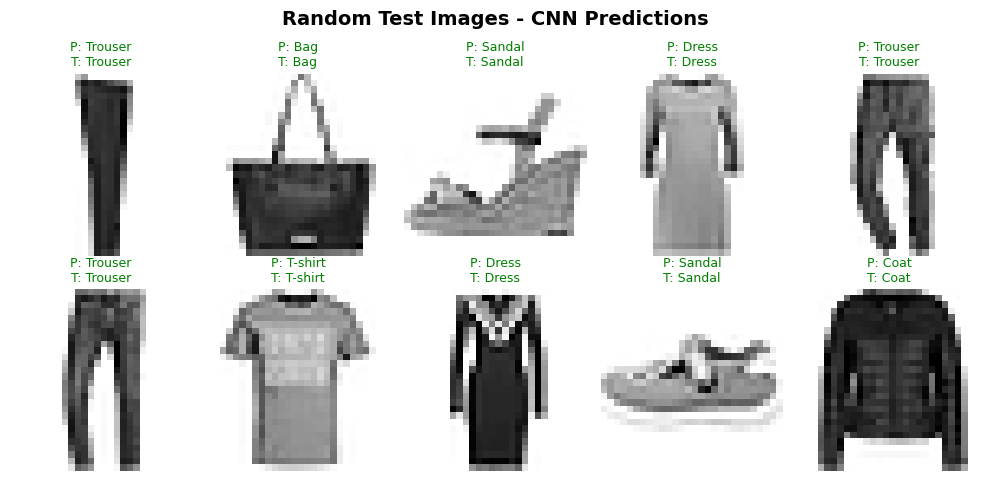

In [44]:
# Set CNN model to evaluation mode
model_cnn.eval()

# Gather all test images and labels
all_images, all_labels = [], []
for imgs, lbls in test_loader:
    all_images.append(imgs)
    all_labels.append(lbls)
images = torch.cat(all_images)
labels = torch.cat(all_labels)

# Randomly select 10 test images
indices = random.sample(range(len(images)), 10)
sample_images = images[indices]
sample_labels = labels[indices]

# Make predictions using CNN
with torch.no_grad():
    outputs = model_cnn(sample_images.to(device))
    _, preds = torch.max(outputs, 1)

# Fashion-MNIST class names
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Plot predictions
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i][0], cmap="binary", interpolation="nearest")
    true_label = classes[sample_labels[i]]
    pred_label = classes[preds[i]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    ax.axis("off")

plt.suptitle("Random Test Images - CNN Predictions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

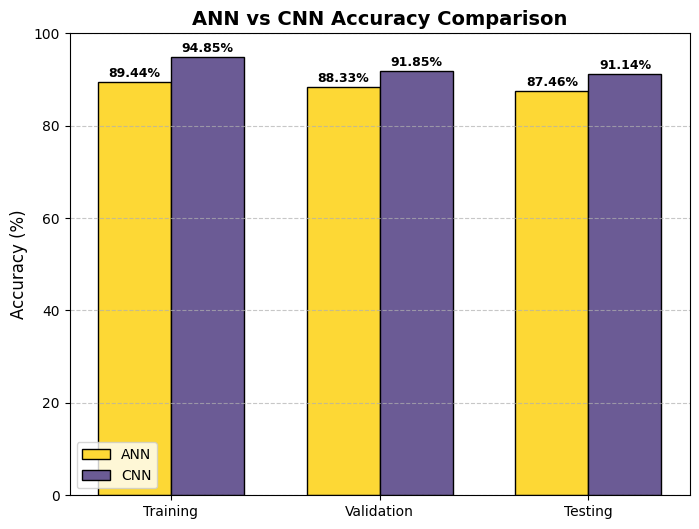

In [45]:
ann_train_acc = train_accuracies[-1]
ann_val_acc   = val_accuracies[-1]
ann_test_acc  = test_accuracy

cnn_train_acc = train_accuracies_cnn[-1]
cnn_val_acc   = val_accuracies_cnn[-1]
cnn_test_acc  = test_accuracy_cnn

#  Data setup
metrics = ['Training', 'Validation', 'Testing']
ann_values = [ann_train_acc, ann_val_acc, ann_test_acc]
cnn_values = [cnn_train_acc, cnn_val_acc, cnn_test_acc]

x = np.arange(len(metrics))
width = 0.35  # width of bars

#  Colors (choose any palette you like)
ann_colors = ['#FDD835']   # pastel reds/oranges for ANN
cnn_colors = ['#6B5B95']   # blues/greens for CNN

#  Plot bars
plt.figure(figsize=(8,6))
bars1 = plt.bar(x - width/2, ann_values, width, label='ANN', color=ann_colors, edgecolor='black')
bars2 = plt.bar(x + width/2, cnn_values, width, label='CNN', color=cnn_colors, edgecolor='black')

#  Labels and titles
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('ANN vs CNN Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

#  Add value labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.2f}%',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.show()


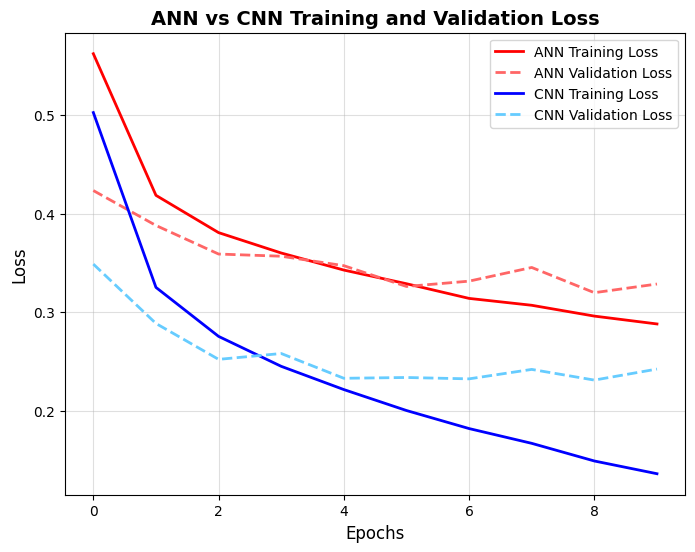

In [46]:
# Plot Training & Validation Loss for ANN vs CNN
plt.figure(figsize=(8,6))

# ANN Loss curves
plt.plot(train_losses, label='ANN Training Loss', linestyle='-', linewidth=2, color='red')
plt.plot(val_losses, label='ANN Validation Loss', linestyle='--', linewidth=2, color='#FF6666')

# CNN Loss curves
plt.plot(train_losses_cnn, label='CNN Training Loss', linestyle='-', linewidth=2, color='blue')
plt.plot(val_losses_cnn, label='CNN Validation Loss', linestyle='--', linewidth=2, color='#66CCFF')

# Formatting
plt.title('ANN vs CNN Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


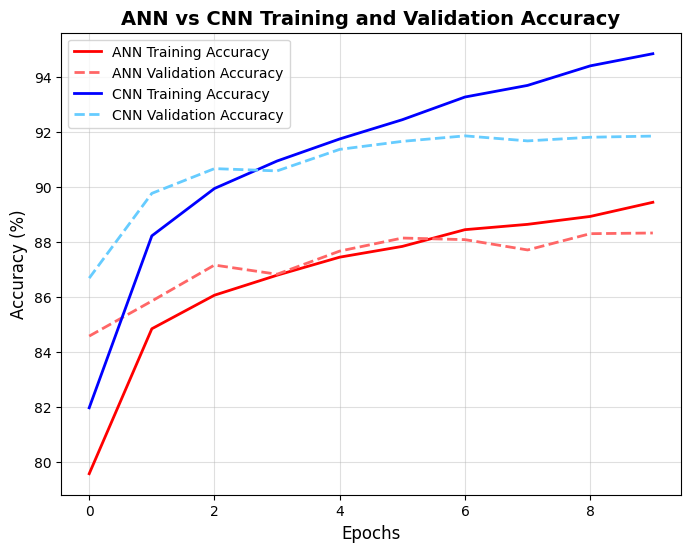

In [47]:
#  Plot Accuracy Curves for ANN and CNN
plt.figure(figsize=(8,6))

# ANN Accuracy
plt.plot(train_accuracies, label='ANN Training Accuracy', linestyle='-', linewidth=2, color='red')
plt.plot(val_accuracies, label='ANN Validation Accuracy', linestyle='--', linewidth=2, color='#FF6666')

# CNN Accuracy
plt.plot(train_accuracies_cnn, label='CNN Training Accuracy', linestyle='-', linewidth=2, color='blue')
plt.plot(val_accuracies_cnn, label='CNN Validation Accuracy', linestyle='--', linewidth=2, color='#66CCFF')

#  Labels and formatting
plt.title('ANN vs CNN Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


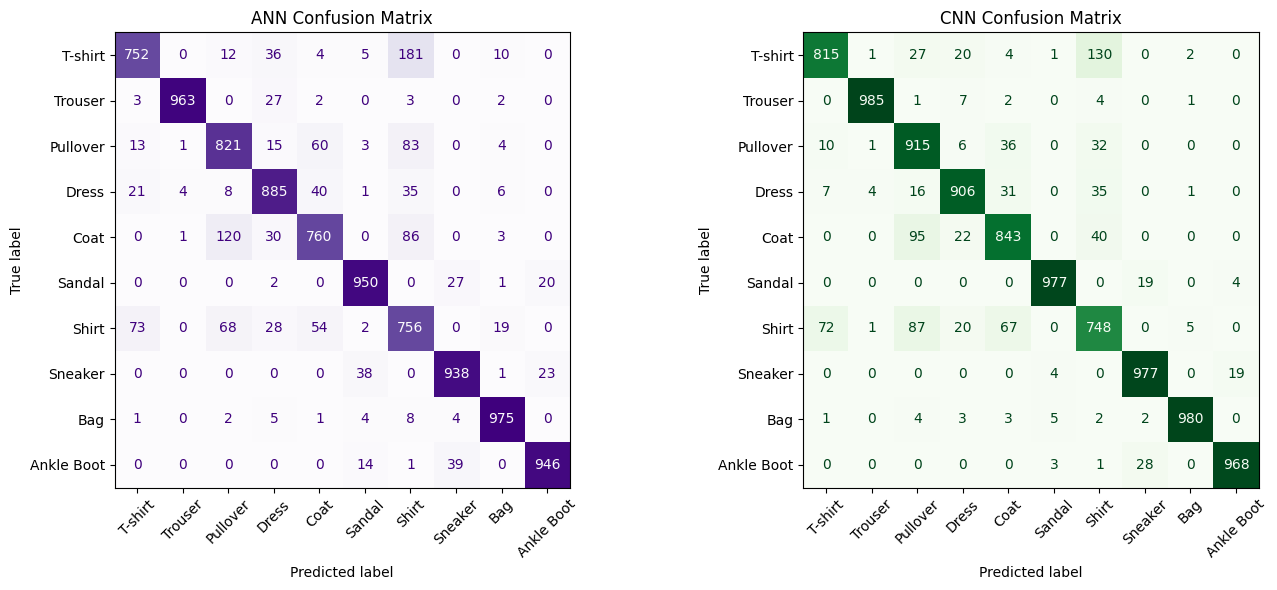

In [48]:
# Switch to evaluation mode
model_ann.eval()

all_preds_ann = []
all_labels_ann = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ann(images)
        _, preds = torch.max(outputs, 1)
        all_preds_ann.extend(preds.cpu().numpy())
        all_labels_ann.extend(labels.cpu().numpy())


#CNN
model_cnn.eval()

all_preds_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, preds = torch.max(outputs, 1)
        all_preds_cnn.extend(preds.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrices
cm_ann = confusion_matrix(all_labels_ann, all_preds_ann)
cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)

class_names = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ANN Confusion Matrix
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=class_names)
disp_ann.plot(cmap="Purples", xticks_rotation=45, ax=axes[0], colorbar=False)
axes[0].set_title("ANN Confusion Matrix")

# CNN Confusion Matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(cmap="Greens", xticks_rotation=45, ax=axes[1], colorbar=False)
axes[1].set_title("CNN Confusion Matrix")

plt.tight_layout()
plt.show()

In [49]:
# Class labels
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# CNN Report
# Use the all_labels_cnn and all_preds_cnn from the previous cell
report_cnn = classification_report(all_labels_cnn, all_preds_cnn, target_names=class_names, output_dict=True)
df_cnn = pd.DataFrame(report_cnn).transpose()

print(" CNN Class-wise Performance")
display(df_cnn[['precision', 'recall', 'f1-score']])

# ANN Report
# Use the all_labels_ann and all_preds_ann from the previous cell
report_ann = classification_report(all_labels_ann, all_preds_ann, target_names=class_names, output_dict=True)
df_ann = pd.DataFrame(report_ann).transpose()

print("\n ANN Class-wise Performance")
display(df_ann[['precision', 'recall', 'f1-score']])

 CNN Class-wise Performance


,precision,recall,f1-score
T-shirt,0.900552,0.8150,0.855643
Trouser,0.992944,0.9850,0.988956
Pullover,0.799127,0.9150,0.853147
Dress,0.920732,0.9060,0.913306
Coat,0.854970,0.8430,0.848943
Sandal,0.986869,0.9770,0.981910
Shirt,0.754032,0.7480,0.751004
Sneaker,0.952242,0.9770,0.964462
Bag,0.990900,0.9800,0.985420
Ankle Boot,0.976791,0.9680,0.972376



 ANN Class-wise Performance


,precision,recall,f1-score
T-shirt,0.871379,0.7520,0.807300
Trouser,0.993808,0.9630,0.978162
Pullover,0.796314,0.8210,0.808469
Dress,0.860895,0.8850,0.872781
Coat,0.825190,0.7600,0.791255
Sandal,0.934120,0.9500,0.941993
Shirt,0.655681,0.7560,0.702276
Sneaker,0.930556,0.9380,0.934263
Bag,0.954946,0.9750,0.964869
Ankle Boot,0.956522,0.9460,0.951232


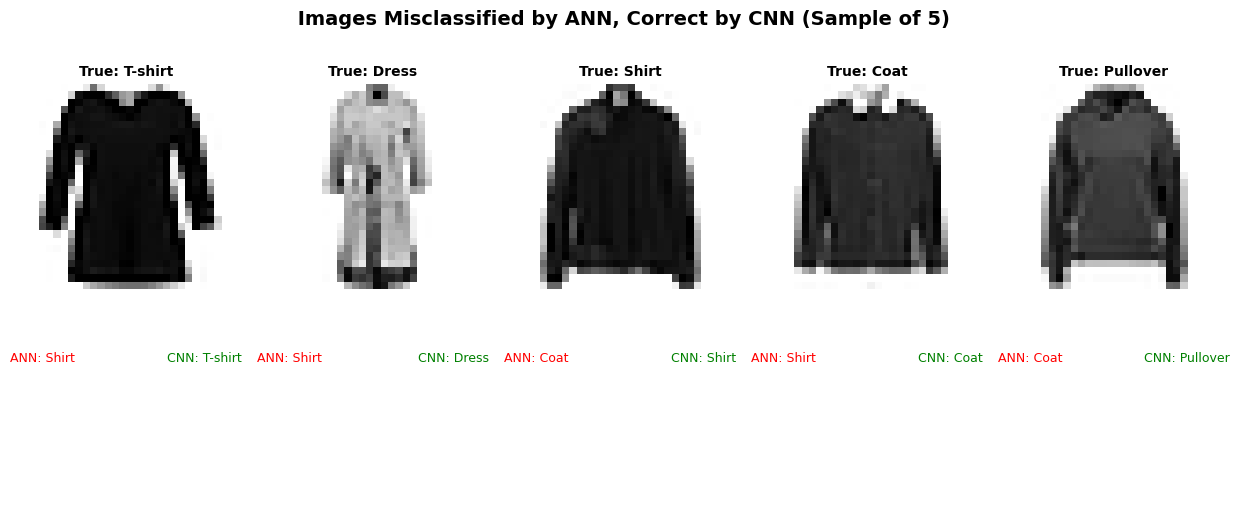

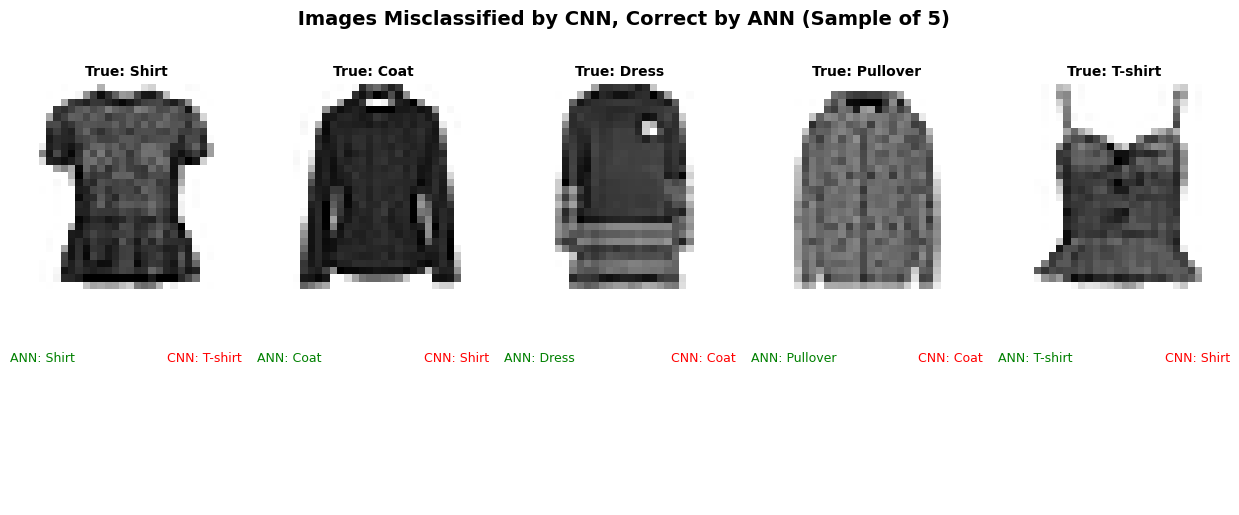

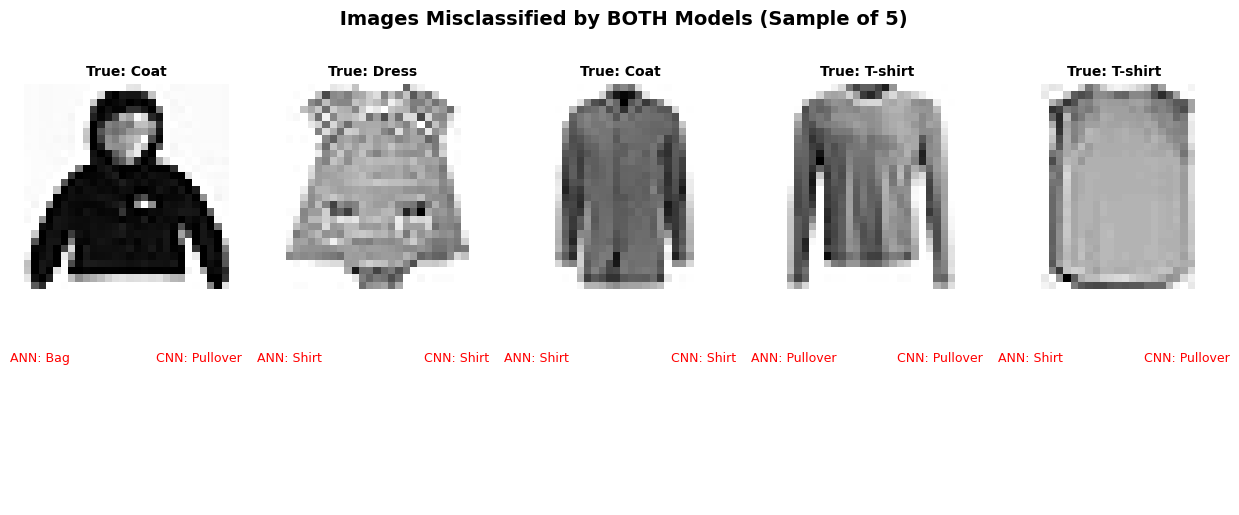

In [50]:
# Set models to evaluation mode
model_ann.eval()
model_cnn.eval()

# Collect all predictions and metadata
all_images = []
all_labels = []
all_preds_ann = []
all_preds_cnn = []
image_indices = []

start_index = 0

with torch.no_grad():
    for images, labels in test_loader:
        images_on_device = images.to(device)
        labels_on_device = labels.to(device)

        # ANN Predictions (requires flattening)
        outputs_ann = model_ann(images_on_device.view(images_on_device.size(0), -1))
        _, preds_ann = torch.max(outputs_ann, 1)

        # CNN Predictions
        outputs_cnn = model_cnn(images_on_device)
        _, preds_cnn = torch.max(outputs_cnn, 1)

        # Store results
        all_images.append(images)
        all_labels.extend(labels.cpu().numpy())
        all_preds_ann.extend(preds_ann.cpu().numpy())
        all_preds_cnn.extend(preds_cnn.cpu().numpy())

        batch_indices = np.arange(start_index, start_index + len(images))
        image_indices.extend(batch_indices)
        start_index += len(images)

# Convert lists to NumPy arrays for easy indexing
all_labels = np.array(all_labels)
all_preds_ann = np.array(all_preds_ann)
all_preds_cnn = np.array(all_preds_cnn)
image_indices = np.array(image_indices)
full_image_tensor = torch.cat(all_images)

# Class names
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]
num_samples_to_show = 5

# Filter images into comparison categories

# Category 1: CNN Correct, ANN Error (CNN is superior)
is_ann_error = (all_labels != all_preds_ann)
is_cnn_correct = (all_labels == all_preds_cnn)
indices_cnn_correct_ann_error = image_indices[is_ann_error & is_cnn_correct]
sample_cnn_correct = random.sample(list(indices_cnn_correct_ann_error), min(num_samples_to_show, len(indices_cnn_correct_ann_error)))

# Category 2: ANN Correct, CNN Error (ANN is superior)
is_ann_correct = (all_labels == all_preds_ann)
is_cnn_error = (all_labels != all_preds_cnn)
indices_ann_correct_cnn_error = image_indices[is_ann_correct & is_cnn_error]
sample_ann_correct = random.sample(list(indices_ann_correct_cnn_error), min(num_samples_to_show, len(indices_ann_correct_cnn_error)))

# Category 3: Both Models Error (Both struggle)
is_both_error = is_ann_error & is_cnn_error
indices_both_error = image_indices[is_both_error]
sample_both_error = random.sample(list(indices_both_error), min(num_samples_to_show, len(indices_both_error)))


# Plot the sampled images

def plot_misclassified_sample(sample_indices, title, model_comparison, fig_num):
    """Plots a sample of misclassified images with true and predicted labels."""
    num_plots = len(sample_indices)

    # Create the figure and axes
    fig, axes = plt.subplots(2, num_plots, figsize=(2.5 * num_plots, 5))
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    for i, idx in enumerate(sample_indices):
        true_label = classes[all_labels[idx]]
        ann_pred = classes[all_preds_ann[idx]]
        cnn_pred = classes[all_preds_cnn[idx]]

        # Top row: Image and True Label
        axes[0, i].imshow(full_image_tensor[idx][0], cmap="binary", interpolation="nearest")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"True: {true_label}", fontsize=10, fontweight='bold')

        # Bottom row: Prediction comparison
        axes[1, i].axis("off")

        ann_color = "green" if ann_pred == true_label else "red"
        cnn_color = "green" if cnn_pred == true_label else "red"

        # Display predictions side-by-side with color coding
        axes[1, i].text(0.0, 0.7, f"ANN: {ann_pred}",
                        fontsize=9, color=ann_color,
                        horizontalalignment='left',
                        transform=axes[1, i].transAxes)

        axes[1, i].text(1.0, 0.7, f"CNN: {cnn_pred}",
                        fontsize=9, color=cnn_color,
                        horizontalalignment='right',
                        transform=axes[1, i].transAxes)

    plt.tight_layout()
    plt.show()

# Execute the plots for each category
plot_misclassified_sample(
    sample_cnn_correct,
    f" Images Misclassified by ANN, Correct by CNN (Sample of {len(sample_cnn_correct)})",
    "CNN Superior", 1
)


plot_misclassified_sample(
    sample_ann_correct,
    f" Images Misclassified by CNN, Correct by ANN (Sample of {len(sample_ann_correct)})",
    "ANN Superior", 2
)


plot_misclassified_sample(
    sample_both_error,
    f" Images Misclassified by BOTH Models (Sample of {len(sample_both_error)})",
    "Both Models Struggle", 3
)